# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Huajian Qiu"
student2 = "Kunteng Wang"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [4]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

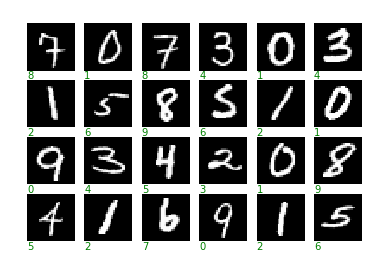

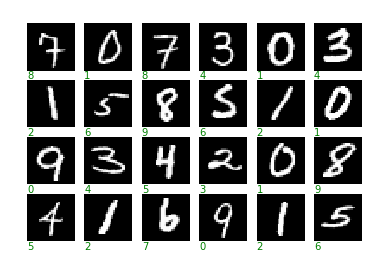

In [5]:
plot_some_samples(x_train,y_train)

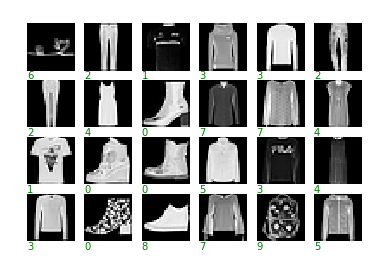

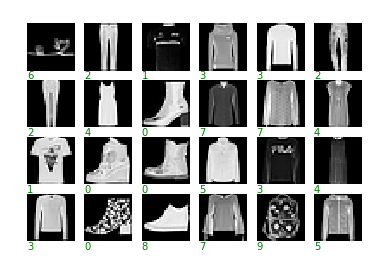

In [6]:
plot_some_samples(x_fashion_train,y_fashion_train)

Answer to question 2: These green digits mean the index of the classification form 0-9.

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [8]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

In [12]:
x_full = np.concatenate((x_train,x_test),axis=0)
y_full = np.concatenate((y_train,y_test),axis=0)

In [27]:
np.random.seed(1)
train_indices = np.random.choice(range(70000), size = 35000, replace = False)
test_indices = np.asarray(list(set(range(70000)) - set(train_indices)))

In [42]:
xx_train = x_full[train_indices]
xx_test = x_full[test_indices]
yy_train = y_full[train_indices]
yy_test = y_full[test_indices]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 35000 samples, validate on 35000 samples
Epoch 1/50
35000/35000 [==============================] - 6s 182us/step - loss: 0.7093 - acc: 0.8179 - val_loss: 0.4456 - val_acc: 0.8816
Epoch 2/50
35000/35000 [==============================] - 2s 48us/step - loss: 0.4162 - acc: 0.8877 - val_loss: 0.3840 - val_acc: 0.8938
Epoch 3/50
35000/35000 [==============================] - 2s 50us/step - loss: 0.3740 - acc: 0.8976 - val_loss: 0.3580 - val_acc: 0.9021
Epoch 4/50
35000/35000 [==============================] - 2s 49us/step - l

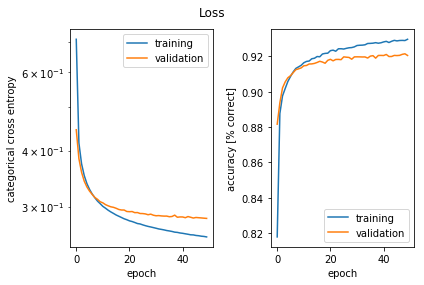

In [44]:
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential([Dense(10, input_shape=(784,)),Activation('softmax')])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

history = model.fit(xx_train, yy_train,
                            batch_size=128,
                            epochs=50,
                            verbose=1,
                            validation_data=(xx_test, yy_test))
fig = plot_history(history, 'Loss')
score = model.evaluate(xx_test, yy_test, verbose = 0)
print('loss_test = ', score[0])
print('accr_test = ', score[1])

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.5884 - acc: 0.8464 - val_loss: 0.3804 - val_acc: 0.8971
Epoch 2/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.3743 - acc: 0.8965 - val_loss: 0.3366 - val_acc: 0.9099
Epoch 3/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.3427 - acc: 0.9044 - val_loss: 0.3189 - val_acc: 0.9133
Epoch 4/50
60000/60000 [==============================] - 1s 15us/step - lo

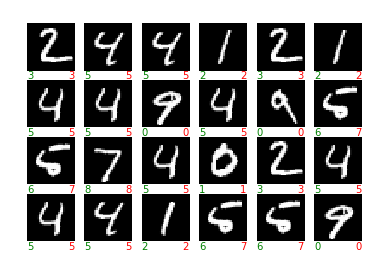

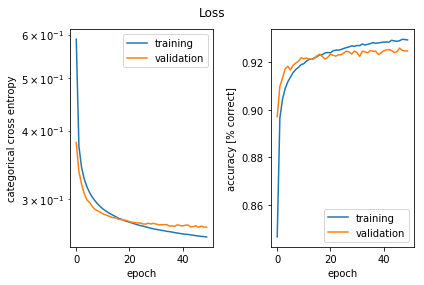

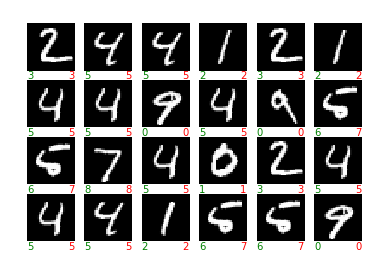

In [10]:
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential([Dense(10, input_shape=(784,)),Activation('softmax')])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

history = model.fit(x_train, y_train,
                            batch_size=128,
                            epochs=50,
                            verbose=1,
                            validation_data=(x_test, y_test))

plot_history(history, 'Loss')

#incorrects = np.nonzero(model.predict(x_test).reshape((-1,)) != y_test)
y_test = np.asarray(y_test)
incorrects=np.where(model.predict(x_test) != y_test)

yhat_test=model.predict(x_test)

plot_some_samples(x_test, y_test, yhat_test, incorrects[1]) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.6918 - acc: 0.7722 - val_loss: 0.5718 - val_acc: 0.8066
Epoch 2/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.5153 - acc: 0.8283 - val_loss: 0.5232 - val_acc: 0.8208
Epoch 3/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.4819 - acc: 0.8372 - val_loss: 0.4976 - val_acc: 0.8300
Epoch 4/50
60000/60000 [==============================] - 2s 28us/step - lo

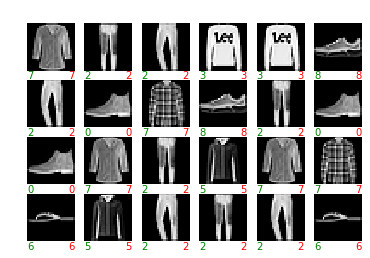

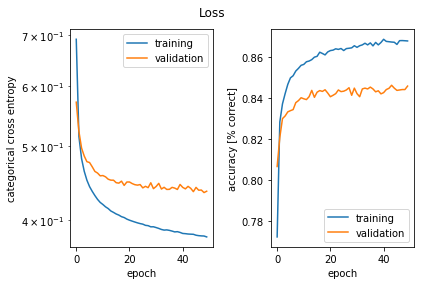

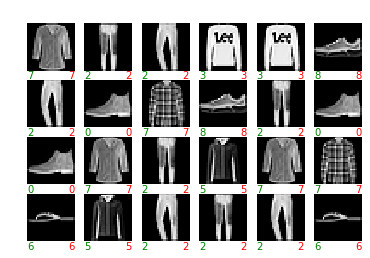

In [10]:
#repeat above with fashion data set
model = Sequential([Dense(10, input_shape=(784,)),Activation('softmax')])
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

history_fashion = model.fit(x_fashion_train, y_fashion_train,
                            batch_size=128,
                            epochs=50,
                            verbose=1,
                            validation_data=(x_fashion_test, y_fashion_test))

plot_history(history_fashion, 'Loss')

#incorrects = np.nonzero(model.predict(x_test).reshape((-1,)) != y_test)
y_fashion_test = np.asarray(y_fashion_test)
incorrects=np.where(model.predict(x_fashion_test) != y_fashion_test)

yhat_fashion_test=model.predict(x_fashion_test)

plot_some_samples(x_fashion_test, y_fashion_test, yhat_fashion_test, incorrects[1]) 

Answer to question 8: The red digits mean the prediction of the classification, while the green digits means the correct classification.

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.5421 - acc: 0.8423 - val_loss: 0.2828 - val_acc: 0.9205
Epoch 2/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.2915 - acc: 0.9160 - val_loss: 0.2172 - val_acc: 0.9384
Epoch 3/50
60000/60000 [==============================] - 2s 36us/step - los

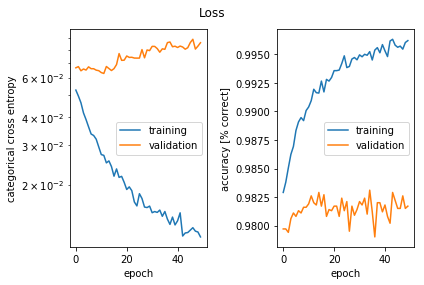

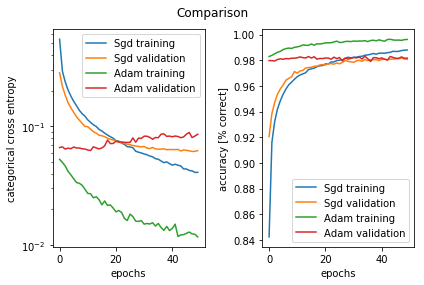

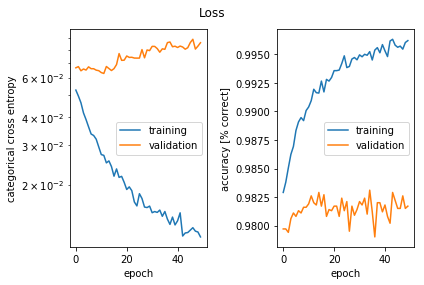

In [14]:
from keras.optimizers import SGD
from keras.optimizers import Adam

#1
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()
#2
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #different learning rate as 0.01
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

history1 = model.fit(x_train, y_train,
                            batch_size=128,
                            epochs=50,
                            verbose=1,
                            validation_data=(x_test, y_test))

#3
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history2 = model.fit(x_train, y_train,
                            batch_size=128,
                            epochs=50,
                            verbose=1,
                            validation_data=(x_test, y_test))

#4
comparison_plot(history1, history2, 'Sgd', 'Adam', 'Comparison')

#5
plot_history(history2, 'Loss')


In [15]:
#compare small and large learning rate
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True) #different learning rate as 0.095
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

history3 = model.fit(x_train, y_train,
                            batch_size=128,
                            epochs=50,
                            verbose=1,
                            validation_data=(x_test, y_test))



Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.0150 - acc: 0.9947 - val_loss: 0.0905 - val_acc: 0.9808
Epoch 2/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.0151 - acc: 0.9951 - val_loss: 0.1017 - val_acc: 0.9804
Epoch 3/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.0170 - acc: 0.9940 - val_loss: 0.0905 - val_acc: 0.9812
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0143 - acc: 0.9950 - val_loss: 0.0903 - val_acc: 0.9809
Epoch 5/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0176 - acc: 0.9942 - val_loss: 0.0876 - val_acc: 0.9813
Epoch 6/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0161 - acc: 0.9947 - val_loss: 0.0900 - val_acc: 0.9813
Epoch 7/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0168 - acc: 0.9942 - val_loss: 0.0895 - val_acc

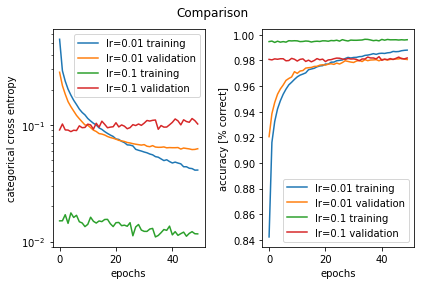

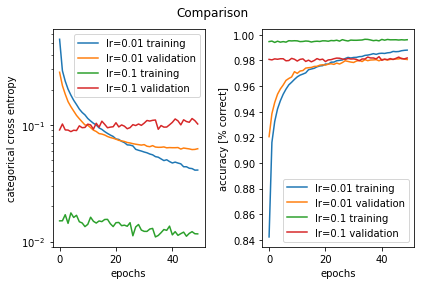

In [17]:
#plot_history(history1, 'Loss')
#plot_history(history3, 'Loss')
comparison_plot(history1, history3, 'lr=0.01', 'lr=0.1', 'Comparison')

In [16]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.5875 - acc: 0.7972 - val_loss: 0.4586 - val_acc: 0.8358
Epoch 2/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.4172 - acc: 0.8522 - val_loss: 0.4037 - val_acc: 0.8576
Epoch 3/50
60000/60000 [==============================] - 2s 40us/step - los

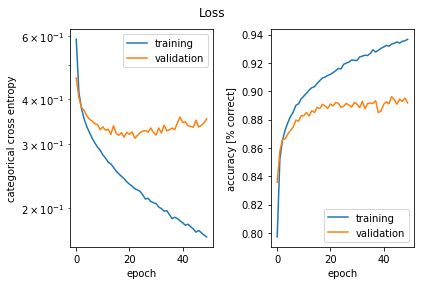

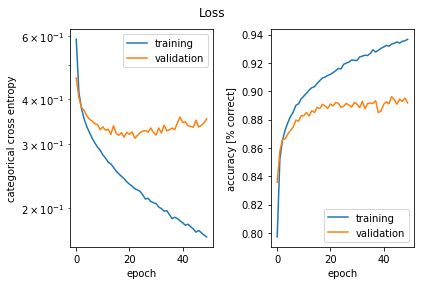

In [21]:
#repeat with fashion dataset
#1
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=784))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()
#2


#3
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history2_fashion = model.fit(x_fashion_train, y_fashion_train,
                            batch_size=128,
                            epochs=50,
                            verbose=1,
                            validation_data=(x_fashion_test, y_fashion_test))

#4


#5
plot_history(history2_fashion, 'Loss')

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) Both loss and accuracy curves would intersect with each other when epochs are around 20.

B) Both loss and accuracy curves are almost parallel to each other.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: The overfitting happens in around 20 epochs.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**:

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [25]:
loss_acc=[]
for i in range(100,1000,100):
    model = Sequential()
    model.add(Dense(i, activation='relu', input_dim=784))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    
    adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

    history = model.fit(x_train, y_train,
                            batch_size=128,
                            epochs=50,
                            verbose=1,
                            validation_data=(x_test, y_test))
    
    score = model.evaluate(x_test, y_test, verbose=0)
    loss_acc.append(score)
    
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 50us/step - loss: 0.4309 - acc: 0.8768 - val_loss: 0.2111 - val_acc: 0.9391
Epoch 2/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.2117 - acc: 0.9385 - val_loss: 0.1476 - val_acc: 0.9571
Epoch 3/50
60000/60000 [==============================] - 2s 28us/step - loss:

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.3584 - acc: 0.8990 - val_loss: 0.1706 - val_acc: 0.9493
Epoch 2/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.1646 - acc: 0.9524 - val_loss: 0.1216 - val_acc: 0.9638
Epoch 3/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.1203 - acc: 0.9649 - val_loss: 0.0952 - val_acc: 0.9703
Epoch 4/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0955 - acc: 0.9719 - val_loss: 0.0843 - val_acc: 0.9732
Epoch 5/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0792 - acc: 0.9769 - val_loss: 0.0804 - val_acc: 0.9737
Epoch 6/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0674 - acc: 0.9796 - val_loss: 0.0735 - val_acc: 0.9782
Epoch 7/50
60000/60000 [==============================] - 2s 39us/step - loss: 0.0591 - acc: 0.9814 - val_loss: 0.0689 - val_acc

60000/60000 [==============================] - 5s 81us/step - loss: 0.0379 - acc: 0.9882 - val_loss: 0.0567 - val_acc: 0.9820
Epoch 8/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.0321 - acc: 0.9897 - val_loss: 0.0597 - val_acc: 0.9818
Epoch 9/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.0271 - acc: 0.9920 - val_loss: 0.0592 - val_acc: 0.9819
Epoch 10/50
60000/60000 [==============================] - 5s 81us/step - loss: 0.0243 - acc: 0.9925 - val_loss: 0.0616 - val_acc: 0.9815
Epoch 11/50
60000/60000 [==============================] - 5s 84us/step - loss: 0.0217 - acc: 0.9930 - val_loss: 0.0601 - val_acc: 0.9820
Epoch 12/50
60000/60000 [==============================] - 5s 81us/step - loss: 0.0179 - acc: 0.9946 - val_loss: 0.0601 - val_acc: 0.9827
Epoch 13/50
60000/60000 [==============================] - 5s 81us/step - loss: 0.0153 - acc: 0.9955 - val_loss: 0.0594 - val_acc: 0.9832
Epoch 14/50
60000/60000 [=======================

60000/60000 [==============================] - 8s 136us/step - loss: 0.0169 - acc: 0.9947 - val_loss: 0.0625 - val_acc: 0.9828
Epoch 12/50
60000/60000 [==============================] - 7s 125us/step - loss: 0.0139 - acc: 0.9957 - val_loss: 0.0604 - val_acc: 0.9823
Epoch 13/50
60000/60000 [==============================] - 8s 128us/step - loss: 0.0130 - acc: 0.9959 - val_loss: 0.0595 - val_acc: 0.9830: 1s - loss: 0.0129  - ETA: 0s - loss: 0.0131 - acc: 0
Epoch 14/50
60000/60000 [==============================] - 7s 119us/step - loss: 0.0105 - acc: 0.9970 - val_loss: 0.0599 - val_acc: 0.9837
Epoch 15/50
60000/60000 [==============================] - 7s 120us/step - loss: 0.0096 - acc: 0.9970 - val_loss: 0.0650 - val_acc: 0.9822
Epoch 16/50
60000/60000 [==============================] - 8s 135us/step - loss: 0.0095 - acc: 0.9970 - val_loss: 0.0584 - val_acc: 0.9838
Epoch 17/50
60000/60000 [==============================] - 7s 120us/step - loss: 0.0093 - acc: 0.9971 - val_loss: 0.0653 - v

60000/60000 [==============================] - 10s 163us/step - loss: 0.0331 - acc: 0.9897 - val_loss: 0.0694 - val_acc: 0.9772
Epoch 7/50
60000/60000 [==============================] - 10s 168us/step - loss: 0.0271 - acc: 0.9916 - val_loss: 0.0576 - val_acc: 0.9813
Epoch 8/50
60000/60000 [==============================] - 10s 172us/step - loss: 0.0223 - acc: 0.9931 - val_loss: 0.0620 - val_acc: 0.9818TA: 4s - loss: 0.02 - ETA: 3s - loss: 0.02 - ETA: 2s - loss: 0.0216 - - ETA: 1s - loss: 0 - ETA: 0s - loss: 0.0223 - ac
Epoch 9/50
60000/60000 [==============================] - 10s 160us/step - loss: 0.0193 - acc: 0.9940 - val_loss: 0.0598 - val_acc: 0.9830
Epoch 10/50
60000/60000 [==============================] - 11s 179us/step - loss: 0.0166 - acc: 0.9947 - val_loss: 0.0625 - val_acc: 0.9816
Epoch 11/50
60000/60000 [==============================] - 11s 181us/step - loss: 0.0131 - acc: 0.9960 - val_loss: 0.0598 - val_acc: 0.9830
Epoch 12/50
60000/60000 [==============================]

In [43]:
loss=[]
acc=[]
for i in range(0,9):
    loss.append(loss_acc[i][0])
    acc.append(loss_acc[i][1])

Text(0, 0.5, 'Loss')

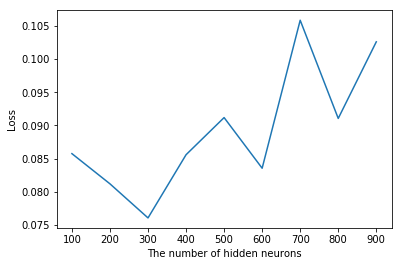

In [49]:
x=range(100,1000,100)
plt.plot(x,loss)
plt.xlabel('The number of hidden neurons')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

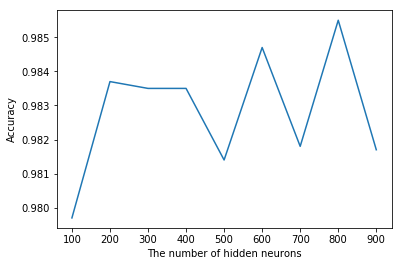

In [50]:
plt.plot(x,acc)
plt.xlabel('The number of hidden neurons')
plt.ylabel('Accuracy')

Answer to question 2: 

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [60]:
#tuned two hidden layers
from keras import regularizers
from keras.layers.normalization import BatchNormalization
model = Sequential()
model.add(Dense(50, input_dim=784,
                kernel_regularizer=regularizers.l2(0.0001),
                bias_regularizer=regularizers.l2(0.0001)))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(50,kernel_regularizer=regularizers.l2(0.0001),bias_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))


model.add(Dense(10,kernel_regularizer=regularizers.l2(0.0001),bias_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('softmax'))
model.summary()

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history_tuned = model.fit(x_fashion_train, y_fashion_train,
                            batch_size=128,
                            epochs=100,
                            verbose=1,
                            validation_data=(x_fashion_test, y_fashion_test))

score = model.evaluate(x_fashion_test, y_fashion_test, verbose=0)
print(score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 50)                39250     
_________________________________________________________________
batch_normalization_88 (Batc (None, 50)                200       
_________________________________________________________________
activation_93 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_89 (Batc (None, 50)                200       
_________________________________________________________________
activation_94 (Activation)   (None, 50)                0         
__________

Epoch 47/100
60000/60000 [==============================] - 5s 76us/step - loss: 0.2769 - acc: 0.9131 - val_loss: 0.4040 - val_acc: 0.8746
Epoch 48/100
60000/60000 [==============================] - 5s 75us/step - loss: 0.2732 - acc: 0.9154 - val_loss: 0.4152 - val_acc: 0.8674
Epoch 49/100
60000/60000 [==============================] - 5s 76us/step - loss: 0.2752 - acc: 0.9137 - val_loss: 0.4123 - val_acc: 0.8744
Epoch 50/100
60000/60000 [==============================] - 5s 76us/step - loss: 0.2714 - acc: 0.9150 - val_loss: 0.4138 - val_acc: 0.8642
Epoch 51/100
60000/60000 [==============================] - 5s 76us/step - loss: 0.2742 - acc: 0.9147 - val_loss: 0.4039 - val_acc: 0.8731
Epoch 52/100
60000/60000 [==============================] - 5s 75us/step - loss: 0.2713 - acc: 0.9149 - val_loss: 0.4012 - val_acc: 0.8716
Epoch 53/100
60000/60000 [==============================] - 5s 78us/step - loss: 0.2726 - acc: 0.9150 - val_loss: 0.3951 - val_acc: 0.8793
Epoch 54/100
60000/60000 [=

In [19]:
#naive two  hidden layers
model = Sequential()
model.add(Dense(50, activation='relu', input_dim=784))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history_naive = model.fit(x_fashion_train, y_fashion_train,
                            batch_size=128,
                            epochs=100,
                            verbose=1,
                            validation_data=(x_fashion_test, y_fashion_test))

score = model.evaluate(x_fashion_test, y_fashion_test, verbose=0)
print(score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                510       
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 32us/step - loss: 0.6082 - acc: 0.7913 - val_loss: 0.4660 - val_acc: 0.8354
Epoch 2/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.4101 - acc: 0.8558 - val_loss: 0.4321 - val_acc: 0.8450
Epoch 3/100
60000/60000 [==============================] - 2s 28us/step - lo

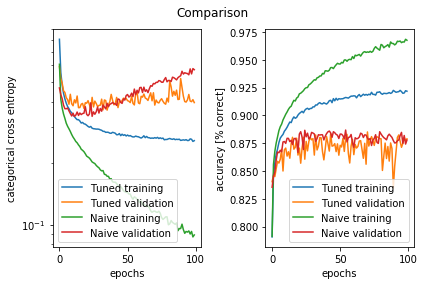

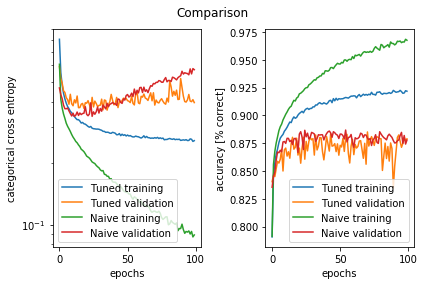

In [61]:
comparison_plot(history_tuned, history_naive, 'Tuned', 'Naive', 'Comparison')

Answer to question 2 (comments): The overfitting is avoided by regularization though both naive validation and tuned validation have oscillation. However,the one-hidden-layer model performs better than the two-hidden-layer model. 

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [73]:
#
from keras import backend as K
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
    
num_classes=10
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history_mnist=model.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

score_mnist = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_mnist[0])
print('Test accuracy:', score_mnist[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1450s 24ms/step - loss: 0.2372 - acc: 0.9281 - val_loss: 0.0506 - val_acc: 0.9836
Epoch 2/5
60000/60000 [==============================] - 1448s 24ms/step - loss: 0.0853 - acc: 0.9751 - val_loss: 0.0386 - val_acc: 0.9870
Epoch 3/5
60000/60000 [==============================] - 1438s 24ms/step - loss: 0.0634 - acc: 0.9805 - val_loss: 0.0342 - val_acc: 0.9893
Epoch 4/5
60000/60000 [==============================] - 1447s 24ms/step - loss: 0.0502 - acc: 0.9850 - val_loss: 0.0371 - val_acc: 0.9892
Epoch 5/5
60000/60000 [==============================] - 1457s 24ms/step - loss: 0.0442 - acc: 0.9869 - val_loss: 0.0331 - val_acc: 0.9893
Test loss: 0.03313420659638796
Test accuracy: 0.9893


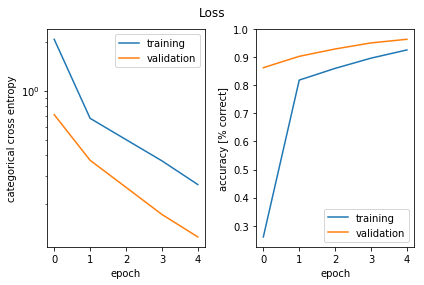

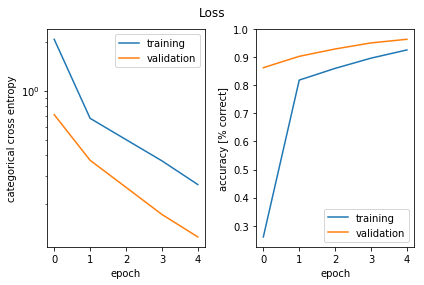

In [78]:
plot_history(history_mnist,'Loss')

In [74]:
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()
if K.image_data_format() == 'channels_first':
    x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], 1, img_rows, img_cols)
    x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], img_rows, img_cols, 1)
    x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
    
num_classes=10
x_fashion_train = x_fashion_train.astype('float32')
x_fashion_test = x_fashion_test.astype('float32')
x_fashion_train /= 255
x_fashion_test /= 255


# convert class vectors to binary class matrices
y_fashion_train = keras.utils.to_categorical(y_fashion_train, num_classes)
y_fashion_test = keras.utils.to_categorical(y_fashion_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history_fashion=model.fit(x_fashion_train, y_fashion_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(x_fashion_test, y_fashion_test))

score_fashion = model.evaluate(x_fashion_test, y_fashion_test, verbose=0)
print('Test loss:', score_fashion[0])
print('Test accuracy:', score_fashion[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1462s 24ms/step - loss: 0.5428 - acc: 0.8087 - val_loss: 0.3435 - val_acc: 0.8760
Epoch 2/5
60000/60000 [==============================] - 1436s 24ms/step - loss: 0.3584 - acc: 0.8726 - val_loss: 0.2955 - val_acc: 0.8896
Epoch 3/5
60000/60000 [==============================] - 1437s 24ms/step - loss: 0.3078 - acc: 0.8889 - val_loss: 0.2667 - val_acc: 0.8989
Epoch 4/5
60000/60000 [==============================] - 1440s 24ms/step - loss: 0.2742 - acc: 0.9010 - val_loss: 0.2497 - val_acc: 0.9070
Epoch 5/5
60000/60000 [==============================] - 1434s 24ms/step - loss: 0.2503 - acc: 0.9087 - val_loss: 0.2416 - val_acc: 0.9139
Test loss: 0.24155764006972313
Test accuracy: 0.9139


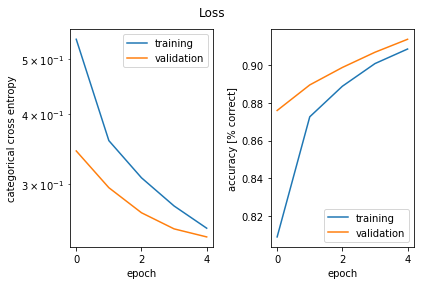

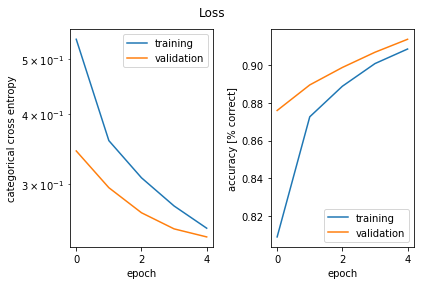

In [79]:
plot_history(history_fashion,'Loss')

Answer to question 3:

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [75]:
from keras import backend as K
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
    
num_classes=10
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='sigmoid'))
model.add(Conv2D(64, (3, 3), activation='sigmoid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history_mnist=model.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

score_mnist = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_mnist[0])
print('Test accuracy:', score_mnist[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1436s 24ms/step - loss: 2.0650 - acc: 0.2603 - val_loss: 0.7112 - val_acc: 0.8621
Epoch 2/5
60000/60000 [==============================] - 1429s 24ms/step - loss: 0.6757 - acc: 0.8179 - val_loss: 0.3734 - val_acc: 0.9025
Epoch 3/5
60000/60000 [==============================] - 1430s 24ms/step - loss: 0.5002 - acc: 0.8597 - val_loss: 0.2548 - val_acc: 0.9286
Epoch 4/5
60000/60000 [==============================] - 1435s 24ms/step - loss: 0.3705 - acc: 0.8960 - val_loss: 0.1737 - val_acc: 0.9502
Epoch 5/5
60000/60000 [==============================] - 1435s 24ms/step - loss: 0.2650 - acc: 0.9252 - val_loss: 0.1264 - val_acc: 0.9631
Test loss: 0.12640335549041629
Test accuracy: 0.9631


In [81]:
from keras import backend as K
img_rows, img_cols = 28, 28
(x_train, y_train), (x_test, y_test) = mnist.load_data()
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
    
num_classes=10
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3)))
#model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(BatchNormalization())
          
model.add(Conv2D(64, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
#model.add(BatchNormalization())
model.add(Activation('sigmoid'))
model.add(BatchNormalization())
          
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

history_mnist=model.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

score_mnist = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score_mnist[0])
print('Test accuracy:', score_mnist[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 1891s 32ms/step - loss: 0.2618 - acc: 0.9212 - val_loss: 0.2852 - val_acc: 0.9077
Epoch 2/5
60000/60000 [==============================] - 1904s 32ms/step - loss: 0.1111 - acc: 0.9668 - val_loss: 0.0634 - val_acc: 0.9795
Epoch 3/5
60000/60000 [==============================] - 1878s 31ms/step - loss: 0.0909 - acc: 0.9733 - val_loss: 0.0623 - val_acc: 0.9811
Epoch 4/5
60000/60000 [==============================] - 1868s 31ms/step - loss: 0.0773 - acc: 0.9765 - val_loss: 0.0509 - val_acc: 0.9841
Epoch 5/5
60000/60000 [==============================] - 1845s 31ms/step - loss: 0.0709 - acc: 0.9784 - val_loss: 0.0772 - val_acc: 0.9761
Test loss: 0.07717791545195506
Test accuracy: 0.9761


Answer to question 1:

Answer to question 2: